In [2]:
%pylab inline
import sk_dsp_comm.sigsys as ss
import sk_dsp_comm.fir_design_helper as fir_d
import sk_dsp_comm.iir_design_helper as iir_d
import sk_dsp_comm.multirate_helper as mrh
import scipy.signal as signal
from IPython.display import Audio, display
from IPython.display import Image, SVG


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing

# Desain dari Persyaratan  Respons Amplitudo

Baik dengan fir_design_helper maupun iir_design_helper, proses desain dimulai dengan menentukan kebutuhan respons amplitudo, seperti frekuensi kritis pada jalur lewat filter, frekuensi kritis pada jalur hentian, riak pada jalur lewat, dan penurunan pada jalur hentian. Jumlah taps atau koefisien (untuk FIR) atau orde filter (untuk IIR) yang diperlukan untuk memenuhi kebutuhan ini kemudian dihitung. Hasilnya adalah koefisien filter yang dikembalikan sebagai array b untuk FIR, dan untuk IIR, baik array b dan a, maupun array sos 2D, yang masing-masing barisnya mewakili kaskade dari topologi bagian kedua orde untuk filter IIR.

Untuk kasus FIR kita memiliki dalam domain Z:

\begin{equation}
H_\text{FIR}(z) = \sum_{k=0}^N b_k z^{-k}
\end{equation}

dengan ndarray b = <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mo stretchy="false">[</mo>
  <msub>
    <mi>b</mi>
    <mn>0</mn>
  </msub>
  <mo>,</mo>
  <msub>
    <mi>b</mi>
    <mn>1</mn>
  </msub>
  <mo>,</mo>
  <mo>&#x2026;</mo>
  <mo>,</mo>
  <msub>
    <mi>b</mi>
    <mi>N</mi>
  </msub>
  <mo stretchy="false">]</mo>
</math> . Untuk kasus IIR kita memiliki dalam domain Z:

\begin{align}
    H_\text{IIR}(z) &= \frac{\sum_{k=0}^M b_k z^{-k}}{\sum_{k=1}^N a_k z^{-k}} \\
    &= \prod_{k=0}^{N_s-1} \frac{b_{k0} + b_{k1} z^{-1} + b_{k2} z^{-2}}{1 + a_{k1} z^{-1} + a_{k2} z^{-2}} = \prod_{k=0}^{N_s-1} H_k(z)
\end{align}

di mana <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>N</mi>
    <mi>s</mi>
  </msub>
  <mo>=</mo>
  <mo fence="false" stretchy="false">&#x230A;</mo>
  <mo stretchy="false">(</mo>
  <mi>N</mi>
  <mo>+</mo>
  <mn>1</mn>
  <mo stretchy="false">)</mo>
  <mrow data-mjx-texclass="ORD">
    <mo>/</mo>
  </mrow>
  <mn>2</mn>
  <mo fence="false" stretchy="false">&#x230B;</mo>
</math> . Untuk bentuk b/a, koefisien disusun sebagai berikut:

In [6]:
b = [0.1, 0.2, 0.3, 0.4]  
a = [1.0, -0.3, 0.4]      

print("Numerator coefficients (b):", b)
print("Denominator coefficients (a):", a)


Numerator coefficients (b): [0.1, 0.2, 0.3, 0.4]
Denominator coefficients (a): [1.0, -0.3, 0.4]


Untuk bentuk sos, setiap baris dari array sos 2D sesuai dengan koefisien dari <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>H</mi>
    <mi>k</mi>
  </msub>
  <mo stretchy="false">(</mo>
  <mi>z</mi>
  <mo stretchy="false">)</mo>
</math>, sebagai berikut:

In [7]:
from scipy.signal import butter, sosfilt

sos = butter(6, 0.5, output='sos')

for i, section in enumerate(sos):
    print(f"Biquad {i}: {section}")


Biquad 0: [ 2.95882236e-02  5.91764473e-02  2.95882236e-02  1.00000000e+00
 -1.11022302e-16  1.73323801e-02]
Biquad 1: [ 1.00000000e+00  2.00000000e+00  1.00000000e+00  1.00000000e+00
 -1.11022302e-16  1.71572875e-01]
Biquad 2: [ 1.00000000e+00  2.00000000e+00  1.00000000e+00  1.00000000e+00
 -2.22044605e-16  5.88790706e-01]


# Desain Filter FIR Fasa Linier

Fokus utama dari modul ini adalah untuk meningkatkan kemampuan dalam merancang filter FIR dengan fasa linier berdasarkan pada persyaratan respons amplitudo yang mudah digunakan.

Kebanyakan desain filter digital dilakukan dengan motivasi untuk mendekati filter ideal. Filter ideal, baik analog maupun digital, bertujuan untuk meneruskan sinyal pada sejumlah frekuensi tertentu sambil memblokir yang lainnya. Dalam merancang filter digital, terdapat beberapa teknik pendekatan yang dapat digunakan oleh perancang. Dalam konteks filter digital, teknik pendekatan biasanya dibagi menjadi dua kategori utama: IIR (Infinite Impulse Response) atau FIR (Finite Impulse Response). Dalam desain filter FIR, terdapat dua teknik yang umum digunakan: metode cut-off dari respons impuls filter ideal dengan penerapan jendela, dan pendekatan optimal dengan equiripple. Meskipun ada juga teknik berbasis pengambilan sampel frekuensi yang populer, namun teknik tersebut tidak akan dibahas dalam konteks ini, meskipun bisa diimplementasikan dengan dukungan scipy.signal. Proses desain filter umumnya dimulai dengan menentukan spesifikasi respons frekuensi yang diinginkan. Respons frekuensi filter dapat dinyatakan dalam berbagai cara, tetapi paling umum adalah melalui respons amplitudo, misalnya, jelaskan bagaimana <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>H</mi>
    <mi>c</mi>
  </msub>
  <mo stretchy="false">(</mo>
  <mi>j</mi>
  <mi mathvariant="normal">&#x3A9;</mi>
  <mo stretchy="false">)</mo>
</math> atau <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>H</mi>
  <mo stretchy="false">(</mo>
  <msup>
    <mi>e</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>j</mi>
      <mi>&#x3C9;</mi>
    </mrow>
  </msup>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <mi>H</mi>
  <mo stretchy="false">(</mo>
  <msup>
    <mi>e</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>j</mi>
      <mn>2</mn>
      <mi>&#x3C0;</mi>
      <mi>f</mi>
      <mrow data-mjx-texclass="ORD">
        <mo>/</mo>
      </mrow>
      <msub>
        <mi>f</mi>
        <mi>s</mi>
      </msub>
    </mrow>
  </msup>
  <mo stretchy="false">)</mo>
</math> seharusnya berperilaku. Desain yang telah selesai mencakup jumlah koefisien (taps) yang diperlukan dan nilai koefisien itu sendiri, yang biasanya berupa bilangan floating-point presisi ganda atau float64 dalam Numpy, dan float64_t dalam C. Gambar 1 di bawah ini menggambarkan persyaratan respons amplitudo yang dibutuhkan untuk filter lowpass, highpass, bandpass, dan bandstop. Frekuensi kritis dinyatakan dalam persyaratan analog dalam Hz. Frekuensi sampling diasumsikan dalam Hz. Gelombang berombak pada jalur lewat dan nilai penurunan pada jalur hentian dinyatakan dalam dB. Penting untuk dicatat bahwa dalam dB, penurunan adalah kebalikan dari gain, artinya, penurunan sebesar -60 dB pada jalur hentian setara dengan gain sebesar 60 dB.

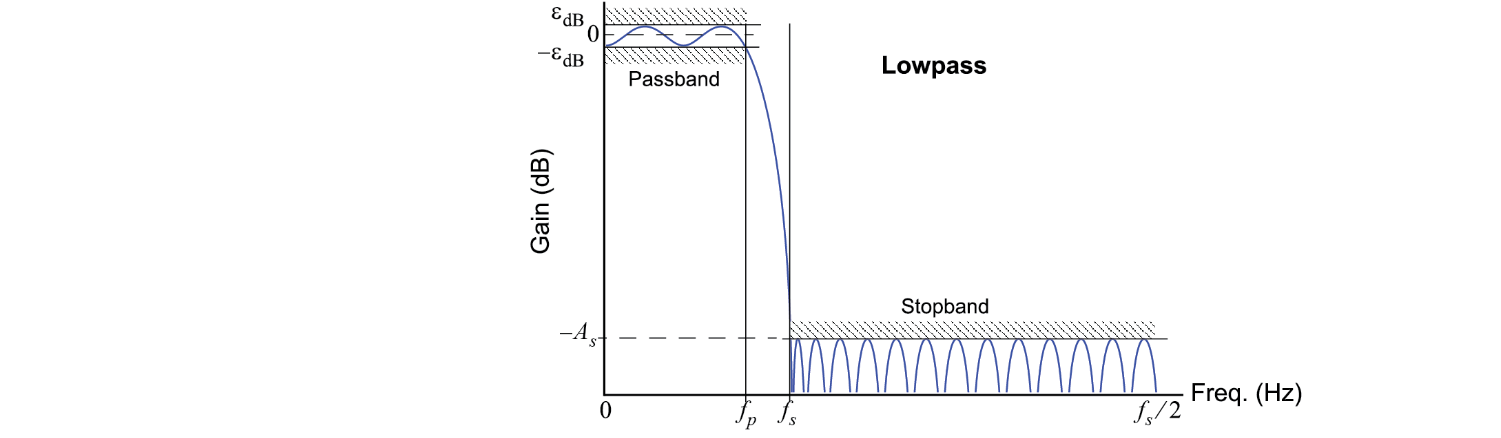

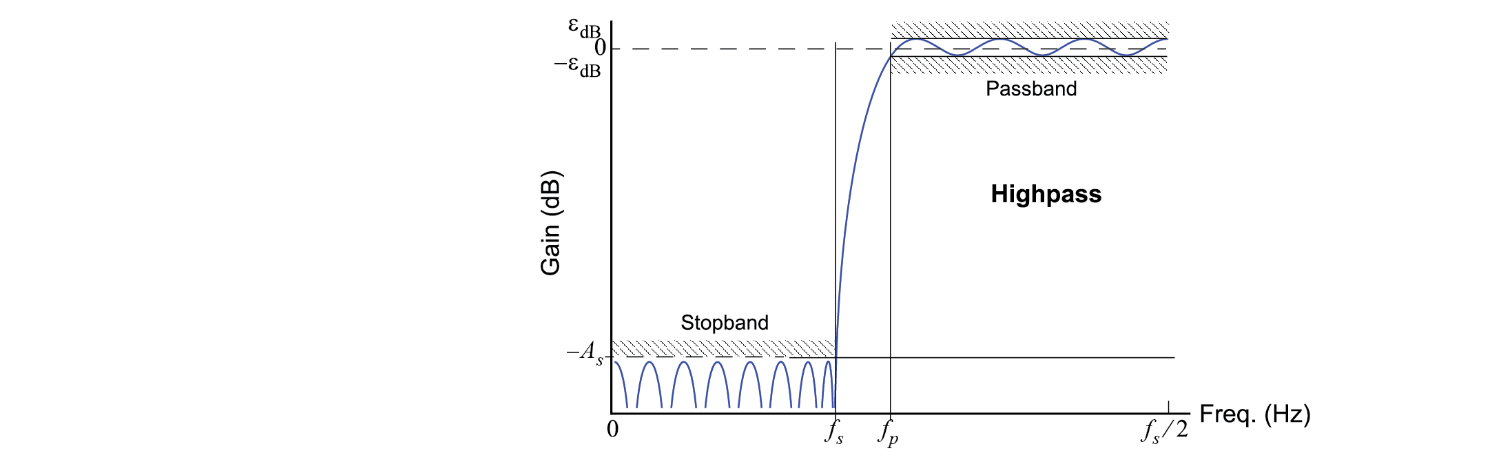

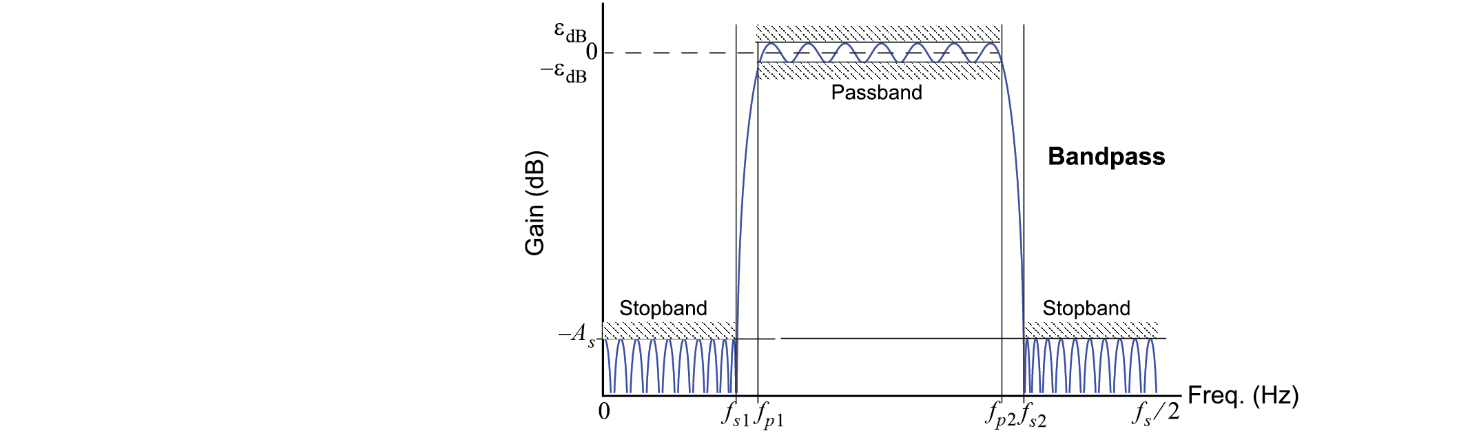

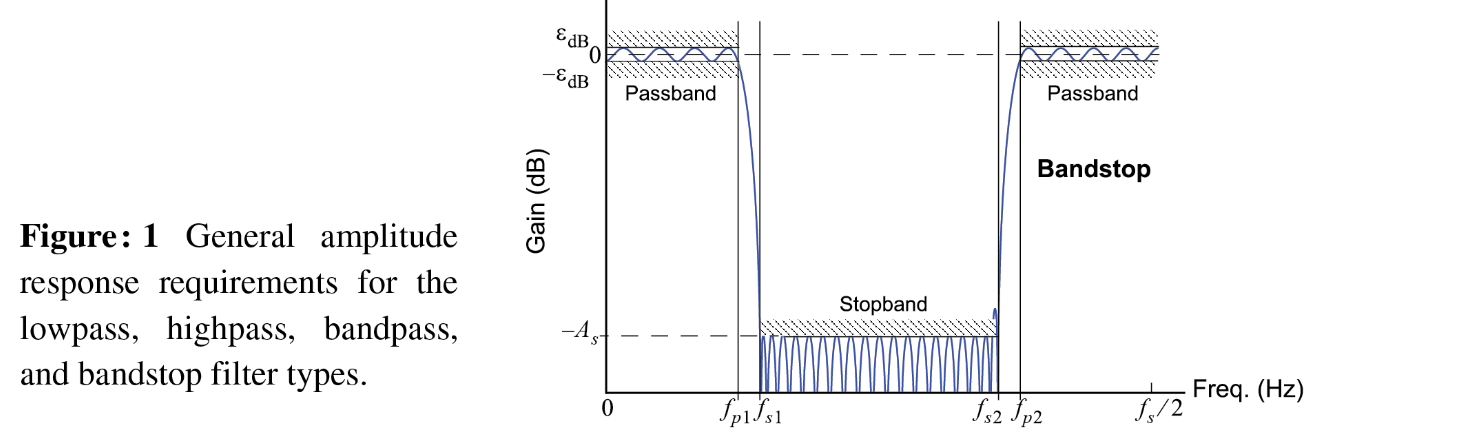

Ada sepuluh fungsi desain filter dan satu fungsi plotting yang tersedia di fir_design_helper.py. Dari sepuluh fungsi tersebut, empat di antaranya digunakan untuk merancang filter FIR dengan menggunakan metode jendela Kaiser, sedangkan empat fungsi lainnya digunakan untuk merancang filter FIR dengan menggunakan metode equiripple. Keempat fungsi yang menggunakan metode jendela Kaiser dan yang menggunakan metode equiripple semua menerima persyaratan respons amplitudo sebagai input dan mengembalikan array koefisien filter sebagai output. Dua dari sepuluh fungsi tersebut berfungsi sebagai pembungkus di sekitar fungsi scipy.signal.firwin() yang digunakan untuk merancang filter dengan urutan tertentu ketika hanya satu (lowpass) atau dua (bandpass) frekuensi kritis yang diberikan. Fungsi pembungkus ini mengatur tipe jendela ke nilai default dari firwin, yaitu hann (hanning). Delapan fungsi lainnya dijelaskan dalam Tabel 1 di bawah ini. Fungsi plotting menyediakan cara mudah untuk membandingkan respons frekuensi yang dihasilkan dari satu atau lebih desain dalam satu plot. Mode tampilan memungkinkan untuk menampilkan gain dalam dB, fase dalam radian, tundaan kelompok dalam sampel, dan tundaan kelompok dalam detik untuk frekuensi pengambilan sampel yang diberikan.Fungsi freq_resp_list() dapat digunakan untuk desain baik filter FIR maupun IIR. Tabel 1 memberikan detail tentang antarmuka untuk delapan fungsi desain, di mana d_stop dan d_pass adalah nilai dB yang positif, dan frekuensi kritis diukur dalam unit yang sama dengan frekuensi pengambilan sampel <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>f</mi>
    <mi>s</mi>
  </msub>
</math>. Fungsi-fungsi ini tidak selalu menghasilkan filter yang optimal, sehingga kadang-kadang perlu dilakukan penyesuaian parameter desain. Penyesuaian ini bisa meliputi peningkatan atau penurunan urutan filter melalui parameter <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>N</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>b</mi>
      <mi>u</mi>
      <mi>m</mi>
      <mi>p</mi>
    </mrow>
  </msub>
</math>.

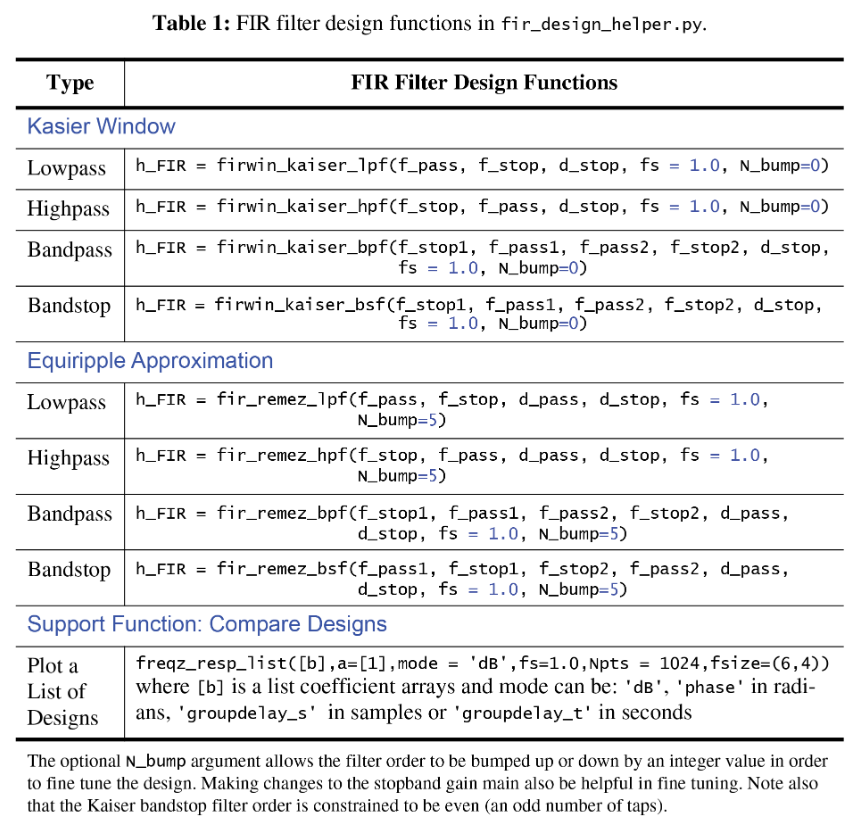

# Contoh Desain

## Contoh 1 Lowpass dengan Fs = 1 Hz

Untuk filter dengan 31 tap ini, kita memilih frekuensi cutoff menjadi <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>F</mi>
    <mi>c</mi>
  </msub>
  <mo>=</mo>
  <msub>
    <mi>F</mi>
    <mi>s</mi>
  </msub>
  <mrow data-mjx-texclass="ORD">
    <mo>/</mo>
  </mrow>
  <mn>8</mn>
</math>, atau dalam bentuk terormalisasi <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>f</mi>
    <mi>c</mi>
  </msub>
  <mo>=</mo>
  <mn>1</mn>
  <mrow data-mjx-texclass="ORD">
    <mo>/</mo>
  </mrow>
  <mn>8</mn>
</math>

In [8]:

b_k = fir_d.firwin_kaiser_lpf(1/8,1/6,50,1.0)
b_r = fir_d.fir_remez_lpf(1/8,1/6,0.2,50,1.0)

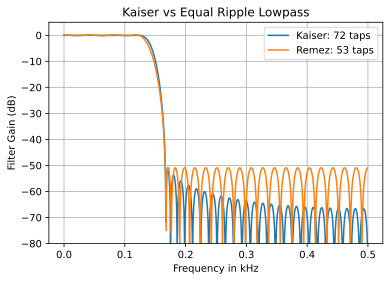

In [9]:
fir_d.freqz_resp_list([b_k,b_r],[[1],[1]],'dB',fs=1)
ylim([-80,5])
title(r'Kaiser vs Equal Ripple Lowpass')
ylabel(r'Filter Gain (dB)')
xlabel(r'Frequency in kHz')
legend((r'Kaiser: %d taps' % len(b_k),r'Remez: %d taps' % len(b_r)),loc='best')
grid();

In [10]:

b_k_hp = fir_d.firwin_kaiser_hpf(1/8,1/6,50,1.0)
b_r_hp = fir_d.fir_remez_hpf(1/8,1/6,0.2,50,1.0)

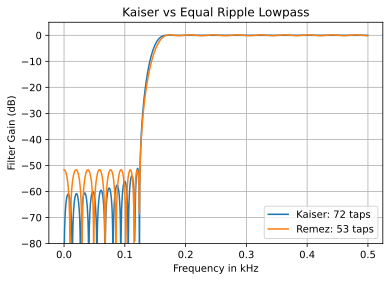

In [11]:
fir_d.freqz_resp_list([b_k_hp,b_r_hp],[[1],[1]],'dB',fs=1)
ylim([-80,5])
title(r'Kaiser vs Equal Ripple Lowpass')
ylabel(r'Filter Gain (dB)')
xlabel(r'Frequency in kHz')
legend((r'Kaiser: %d taps' % len(b_k),r'Remez: %d taps' % len(b_r)),loc='best')
grid();

In [12]:
b_k_bp = fir_d.firwin_kaiser_bpf(7000,8000,14000,15000,50,48000)
b_r_bp = fir_d.fir_remez_bpf(7000,8000,14000,15000,0.2,50,48000)

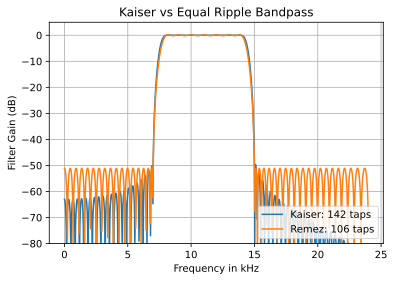

In [13]:
fir_d.freqz_resp_list([b_k_bp,b_r_bp],[[1],[1]],'dB',fs=48)
ylim([-80,5])
title(r'Kaiser vs Equal Ripple Bandpass')
ylabel(r'Filter Gain (dB)')
xlabel(r'Frequency in kHz')
legend((r'Kaiser: %d taps' % len(b_k_bp),
        r'Remez: %d taps' % len(b_r_bp)),
       loc='lower right')
grid();

# Contoh Desain yang Berguna untuk Interpolasi atau Desimasi

Kita akan mempertimbangkan desain filter lowpass yang harus melewati rentang frekuensi dari [0, 4000] Hz dengan frekuensi sampling sebesar 96000 Hz. Situasi ini sering muncul saat kita membangun interpolator menggunakan kelas-kelas dari modul multirate_helper.py dalam scikit-dsp-comm. Interpolator ini bertujuan untuk meningkatkan frekuensi sampling dari 8000 Hz menjadi 96000 Hz, yang berarti faktor interpolasi sebesar L=12. Perlu diperhatikan bahwa pada bagian awal notebook ini kami telah melakukan impor yang diperlukan untuk melanjutkan proses ini.

In [14]:
import sk_dsp_comm.multirate_helper as mrh

sehingga beberapa fungsionalitas dapat diakses. Untuk lebih detail tentang penggunaan multirate_helper

Mulailah dengan desain equalripple yang memiliki transition band yang terpusat pada 4000 Hz dengan ripple passband sebesar 0.5 dB dan attenuasi stopband sebesar 60 dB.0 rh

In [15]:
b_up = fir_d.fir_remez_lpf(3300,4300,0.5,60,96000)

In [16]:
mr_up = mrh.multirate_FIR(b_up)

+ Pertimbangkan konfigurasi pole-zero untuk filter berorde tinggi ini.

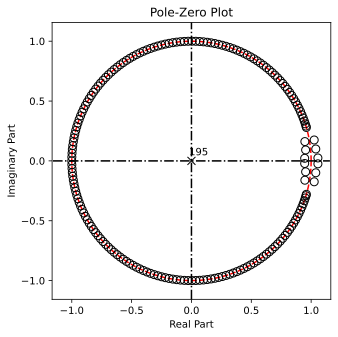

In [17]:
mr_up.zplane()

+ Periksa penguatan pada jalur passband dan stopband.

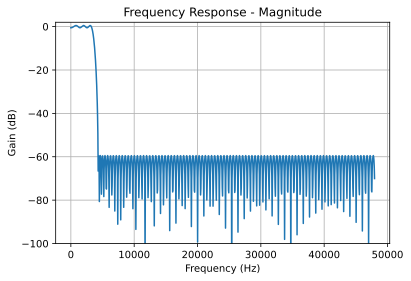

In [18]:
mr_up.freq_resp('db',96000)

+ Perhatikan bahwa delay grup adalah nilai yang diharapkan dari <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mo stretchy="false">(</mo>
  <msub>
    <mi>N</mi>
    <mtext>taps</mtext>
  </msub>
  <mo>&#x2212;</mo>
  <mn>1</mn>
  <mo stretchy="false">)</mo>
  <mrow data-mjx-texclass="ORD">
    <mo>/</mo>
  </mrow>
  <mn>2</mn>
  <mo>=</mo>
  <mn>98</mn>
</math> sampel.

In [19]:
(len(b_up-1))/2

98.0

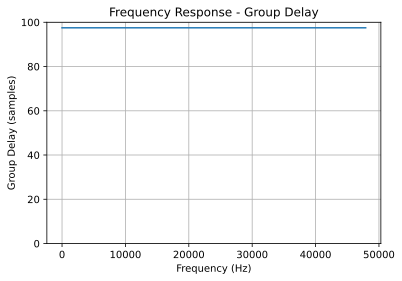

In [20]:
mr_up.freq_resp('groupdelay_s',96000,[0,100])


Objek mr_up sekarang dapat digunakan untuk interpolasi atau desimasi dengan faktor perubahan laju sebesar 12.

# Desain Filter IIR Tradisional Meggunakan Bilinear Transform

Paket scipy.signal menyediakan dukungan penuh untuk merancang filter digital IIR (Infinite Impulse Response) berdasarkan pada prototipe analog. Seperti halnya filter FIR, desain filter IIR biasanya dilakukan dengan mempertimbangkan persyaratan respons amplitudo. Berbagai fungsi desain telah disediakan langsung oleh scipy.signal, terutama fungsi scipy.signal.iirdesign(), yang memungkinkan pengguna untuk merancang filter lowpass, highpass, bandpass, dan bandstop dengan mudah. Untuk menjaga konsistensi dengan modul fir_design_helper.py, modul iir_design_helper.py telah ditulis. Gambar 2, yang disajikan di bawah ini, memberikan penjelasan tentang bagaimana parameter respons amplitudo ditentukan secara grafis.

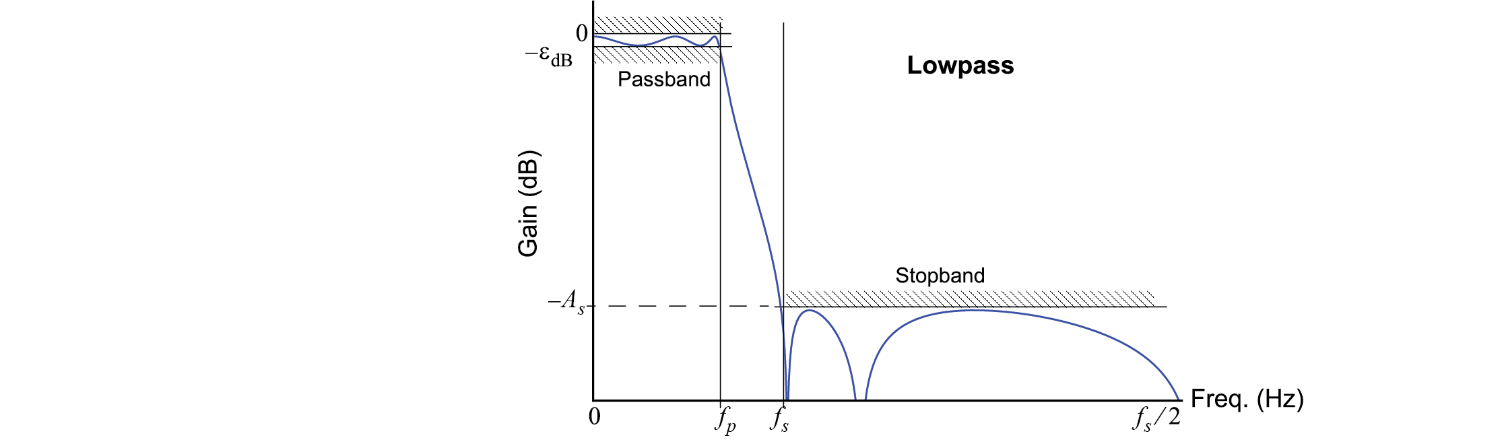

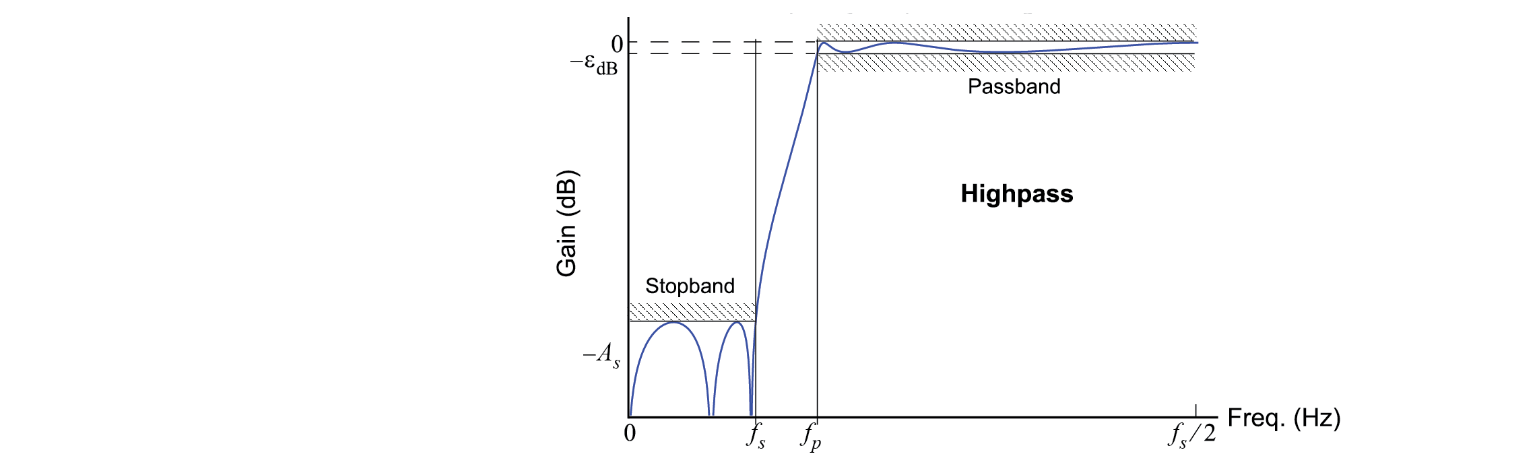

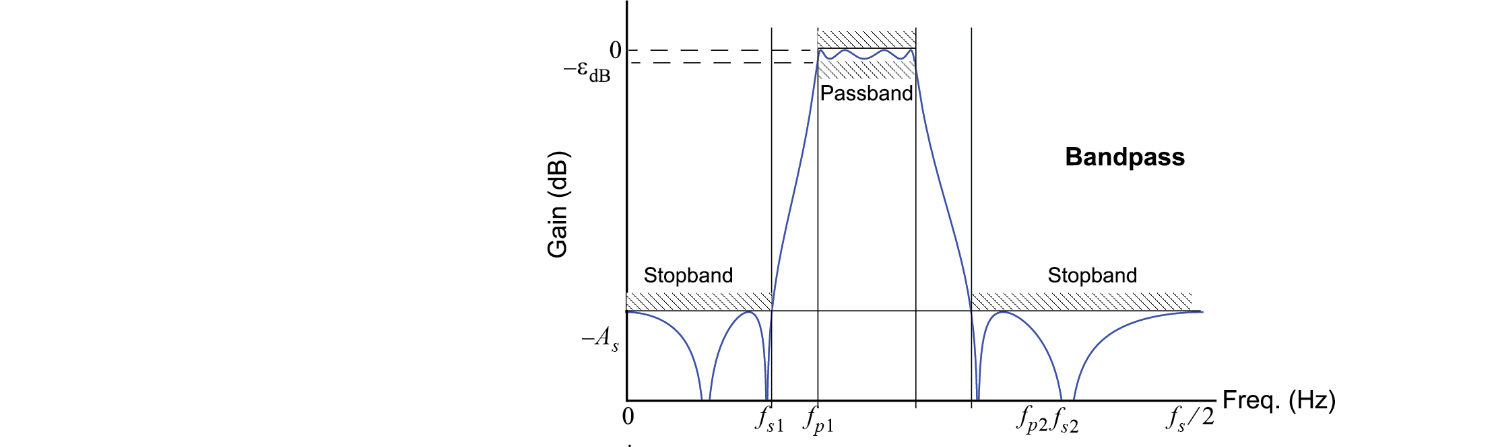

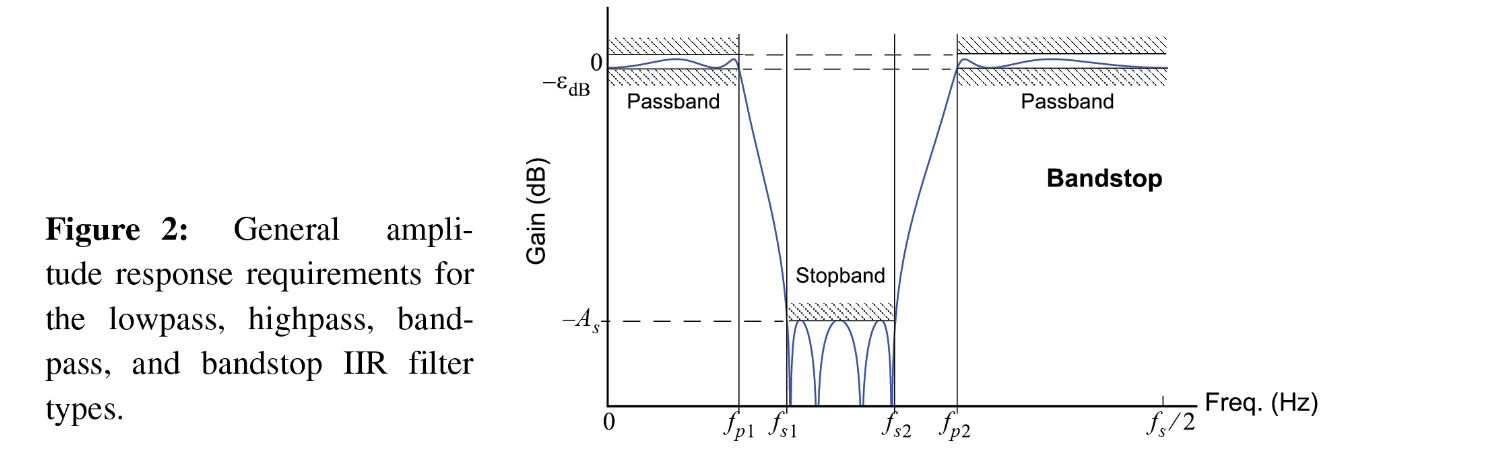

Di dalam modul iir_design_helper.py, terdapat empat fungsi desain filter serta beberapa fungsi pendukung yang tersedia. Keempat fungsi desain filter ini berguna untuk merancang filter lowpass, highpass, bandpass, dan bandstop dengan menggunakan prototipe filter Butterworth, Chebyshev tipe 1, Chebyshev tipe 2, dan eliptikal. Untuk mendapatkan informasi lebih detail mengenai desain filter tersebut, Anda dapat merujuk pada dokumentasi yang disediakan. Antarmuka dari fungsi-fungsi tersebut dijelaskan dalam Tabel 2.

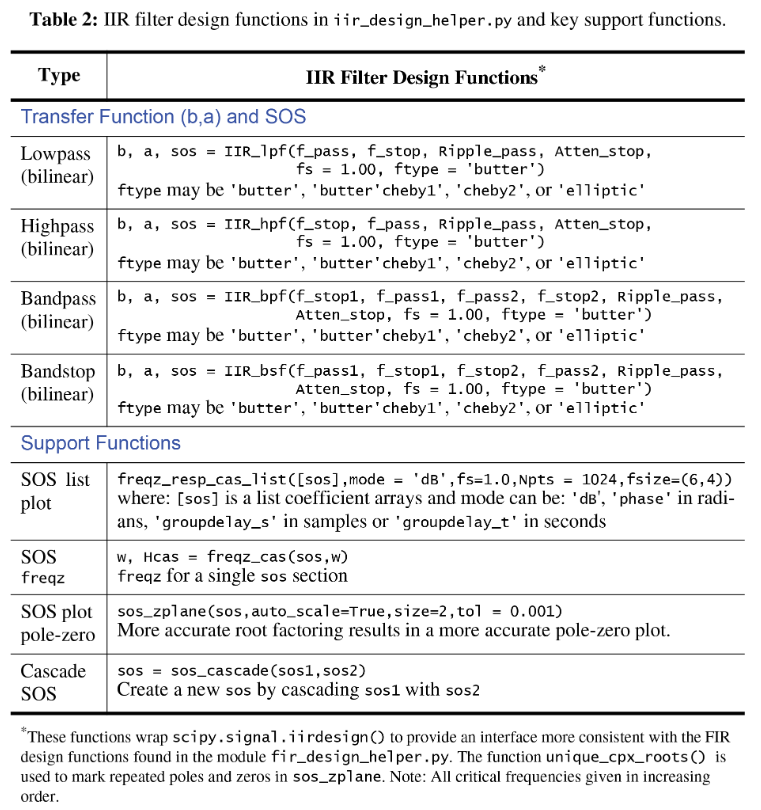

Fungsi filter mengembalikan koefisien filter dalam dua format:
+ Dalam bentuk fungsi transfer tradisional sebagai array koefisien pembilang dan koefisien penyebut a
+ Dalam bentuk rangkaian dari bagian biquadratic menggunakan matriks atau array sos yang sebelumnya diperkenalkan.

Ada dua format yang disediakan untuk memungkinkan analisis lebih lanjut dengan topologi bentuk langsung atau bentuk sos. Fungsi dasar signal.iirdesgn() juga menyediakan opsi ketiga: daftar pole dan zero. Format bentuk sos diinginkan untuk filter presisi tinggi karena lebih tahan terhadap kuantisasi koefisien, meskipun menggunakan koefisien dengan presisi ganda dalam array b dan a.

Dari fungsi pendukung yang tersisa, empat juga dijelaskan dalam Tabel 2 di atas. Fungsi yang paling signifikan dalah freqz_resp_cs_list, yang tersedia untuk membandingkan respons frekuensi secara grafis di beberapa desai, dan soszplane sebuah fungsi untuk memplot pola pole-zero. Keduanya beroperasi menggunakan mtris sos. Sebuah bentuk fungsi tr(sfe (b/a) untuk memplot respons frekensi, freqz_rep_list, juga ada dalam modul ini. Fungsi ini pertama kali diperkenalkan dalam bagian desain FIR. Fungsi plotting respons frekuensi menawarkan mode untuk gain dalam dB, fase dalam radian, delay grup dalam sampel, dan delay grup dalam detik, semua untuk sampling rate tertentu dalam Hz yang diberikan. Fungsi plotting pole-zero mengidentifikasi pole dan zero dengan lebih akurat daipada sk_dsp_commsigsyszplane, karena fungsinumpy oots() hanya menyelesaikan polinomial kuadrat. Juga, akar berulang dapat ditampilkan seperti yang diharapkan secara teoretis, dan juga diperhatikan dalam tampilan grafis dengan superskrip di samping penanda pole dan zero

# Desai IIR Berdasarkan Transformasi Bilinear

Terdapat beberapa metode untuk merancang filter IIR berdasarkan pada persyaratan respons amplitudo. Salah satu metode yang umum digunakan adalah dengan menggunakan transformasi bilinear untuk mengaproksimasi respons filter ke prototipe analog seperti Butterworth, Chebyshev, dan sebagainya. Fungsi signal.iirdesign() yang telah dijelaskan sebelumnya melakukan ini dengan akurat.

Dalam contoh di bawah ini, kita akan mempertimbangkan persyaratan respons amplitudo lowpass dan melihat bagaimana urutan filter berubah ketika kita memilih prototipe analog yang berbeda.

# Contoh: Perbandingan Desain Lowpass

Persyaratan respons amplitudo lowpass dengan <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>f</mi>
    <mi>s</mi>
  </msub>
  <mo>=</mo>
  <mn>48</mn>
</math> adalah:

+ <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>f</mi>
    <mtext>pass</mtext>
  </msub>
  <mo>=</mo>
  <mn>5</mn>
</math>

+ <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>f</mi>
    <mtext>stop</mtext>
  </msub>
  <mo>=</mo>
  <mn>8</mn>
</math>

+ Ripple passband sebesar 0.5 dB

+ Attenuasi stopband sebesar 60 dB

Rancang empat filter untuk memenuhi persyaratan yang sama: butter, cheby1, cheby2, dan ellip:

In [22]:
fs = 48000
f_pass = 5000
f_stop = 8000
b_but,a_but,sos_but = iir_d.IIR_lpf(f_pass,f_stop,0.5,60,fs,'butter')
b_cheb1,a_cheb1,sos_cheb1 = iir_d.IIR_lpf(f_pass,f_stop,0.5,60,fs,'cheby1')
b_cheb2,a_cheb2,sos_cheb2 = iir_d.IIR_lpf(f_pass,f_stop,0.5,60,fs,'cheby2')
b_elli,a_elli,sos_elli = iir_d.IIR_lpf(f_pass,f_stop,0.5,60,fs,'ellip')

# Perbandingan Respons Frekuensi

Di sini kita akan membandingkan respons magnitudo dalam dB dari masing-masing filter menggunakan bentuk sos sebagai input. Dari hasil perbandingan tersebut, kita dapat melihat bahwa filter eliptikal merupakan yang paling efisien, bahkan berhasil melebihi persyaratan stopband dengan mencapai kurang dari 8 kHz.

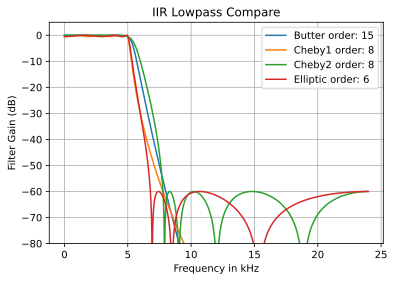

In [23]:
iir_d.freqz_resp_cas_list([sos_but,sos_cheb1,sos_cheb2,sos_elli],'dB',fs=48)
ylim([-80,5])
title(r'IIR Lowpass Compare')
ylabel(r'Filter Gain (dB)')
xlabel(r'Frequency in kHz')
legend((r'Butter order: %d' % (len(a_but)-1),
        r'Cheby1 order: %d' % (len(a_cheb1)-1), 
        r'Cheby2 order: %d' % (len(a_cheb2)-1), 
        r'Elliptic order: %d' % (len(a_elli)-1)),loc='best')
grid();


Selanjutnya, plot konfigurasi pole-zero dari desain butterworth saja. Di sini kita menggunakan versi khusus dari ss.zplane yang berfungsi dengan array 2D sos

(15, 15)

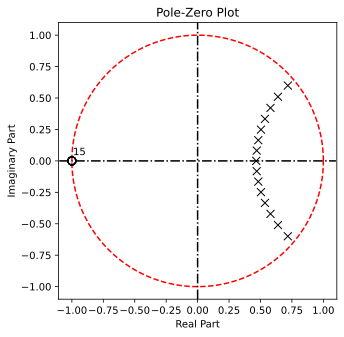

In [24]:

iir_d.sos_zplane(sos_but)

Perlu dicatat bahwa dua plot sebelumnya juga bisa didapatkan menggunakan bentuk fungsi transfer dengan menggunakan iir_d.freqz_resp_list([b],[a],'dB',fs=48) dan ss.zplane(b,a) masing-masing. Namun, menggunakan bentuk sos cenderung memberikan hasil yang lebih akurat karena kurang sensitif terhadap kuantisasi koefisien. Ini terutama berlaku untuk plot pole-zero, karena mengakarkan polinomial derajat ke-15 jauh lebih rentan terhadap kesalahan dibandingkan dengan mengakarkan polinomial kuadrat yang lebih sederhana.

Pada filter Butterworth orde ke-15, transformasi bilinear memetakan 15 nol domain-s ke tak hingga menjadi <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>z</mi>
  <mo>=</mo>
  <mo>&#x2212;</mo>
  <mn>1</mn>
</math>. Jika Anda menggunakan `sk_dsp_comm.sigsys.zplane()`, Anda akan menemukan bahwa ke-15 nol tersebut berada dalam lingkaran rapat di sekitar <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>z</mi>
  <mo>=</mo>
  <mo>&#x2212;</mo>
  <mn>1</mn>
</math>, yang menunjukkan adanya kesalahan dalam proses merooting polinomial. Hal serupa juga berlaku untuk respons frekuensi yang akan menjadi lebih akurat dengan menggunakan bentuk sos.

Pemfilteran sinyal dari array x dilakukan menggunakan desain filter dengan fungsi dari scipy.signal:

+ Untuk bentuk fungsi transfer y = signal.lfilter(b,a,x)

+ Untuk bentuk sos y = signal.sosfilt(sos,x)sos,x)`

# Desain Filter Half-Band untuk Melewati hingga W/2 saat Fs = 8 kHz

Di sini kita mempertimbangkan desain lowpass yang perlu melewati frekuensi hingga <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>f</mi>
    <mi>s</mi>
  </msub>
  <mrow data-mjx-texclass="ORD">
    <mo>/</mo>
  </mrow>
  <mn>4</mn>
</math>. Secara khusus ketika <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>f</mi>
    <mi>s</mi>
  </msub>
  <mo>=</mo>
  <mn>8000</mn>
</math>Hz, Rentang frekuensi passband filter telah diatur menjadi [0, 2000] Hz. Setelah koefisien filter ditemukan, dibuatlah sebuah objek mrh.multirat untuk memungkinkan analisis lebih lanjut terhadap filter, dan akhirnya dilakukan proses filtering terhadap sinyal white noise.

Langkah awalnya adalah merancang filter eliptikal yang memiliki rentang transisi yang terpusat pada 2000 Hz, dengan kedalaman variasi passband sebesar 0.5 dB dan tingkat redaman stopband sebesar 80 dB. Lebar bandwidth transisi diatur menjadi 100 Hz, di mana 50 Hz di setiap sisi dari 2000 Hz.

In [25]:
b_lp,a_lp,sos_lp = iir_d.IIR_lpf(1950,2050,0.5,80,8000.,'ellip')
mr_lp = mrh.multirate_IIR(sos_lp)

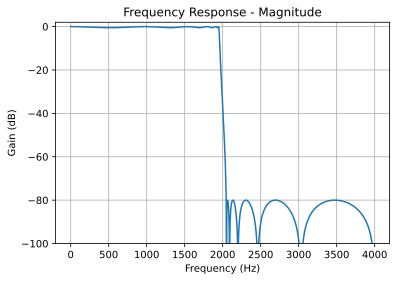

In [26]:
mr_lp.freq_resp('db',8000)

Lewatkan white noise Gaussian dengan varians <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msubsup>
    <mi>&#x3C3;</mi>
    <mi>x</mi>
    <mn>2</mn>
  </msubsup>
  <mo>=</mo>
  <mn>1</mn>
</math> melalui filter. Gunakan banyak sampel sehingga estimasi spektral dapat membentuk dengan akurat <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>S</mi>
    <mi>y</mi>
  </msub>
  <mo stretchy="false">(</mo>
  <mi>f</mi>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <msubsup>
    <mi>&#x3C3;</mi>
    <mi>x</mi>
    <mn>2</mn>
  </msubsup>
  <mo>&#x22C5;</mo>
  <mo data-mjx-texclass="ORD" stretchy="false">|</mo>
  <mi>H</mi>
  <mo stretchy="false">(</mo>
  <msup>
    <mi>e</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>j</mi>
      <mn>2</mn>
      <mi>&#x3C0;</mi>
      <mi>f</mi>
      <mrow data-mjx-texclass="ORD">
        <mo>/</mo>
      </mrow>
      <msub>
        <mi>f</mi>
        <mi>s</mi>
      </msub>
    </mrow>
  </msup>
  <mo stretchy="false">)</mo>
  <msup>
    <mo data-mjx-texclass="ORD" stretchy="false">|</mo>
    <mn>2</mn>
  </msup>
  <mo>=</mo>
  <mo data-mjx-texclass="ORD" stretchy="false">|</mo>
  <mi>H</mi>
  <mo stretchy="false">(</mo>
  <msup>
    <mi>e</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>j</mi>
      <mn>2</mn>
      <mi>&#x3C0;</mi>
      <mi>f</mi>
      <mrow data-mjx-texclass="ORD">
        <mo>/</mo>
      </mrow>
      <msub>
        <mi>f</mi>
        <mi>s</mi>
      </msub>
    </mrow>
  </msup>
  <mo stretchy="false">)</mo>
  <msup>
    <mo data-mjx-texclass="ORD" stretchy="false">|</mo>
    <mn>2</mn>
  </msup>
</math>

(-130.0, -30.0)

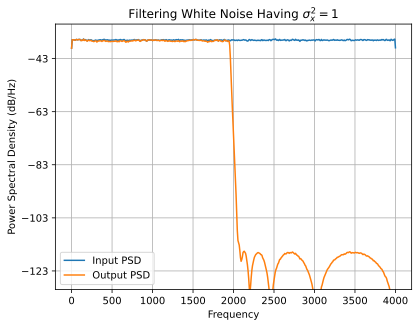

In [27]:
x = randn(1000000)
y = mr_lp.filter(x)
psd(x,2**10,8000);
psd(y,2**10,8000);
title(r'Filtering White Noise Having $\sigma_x^2 = 1$')
legend(('Input PSD','Output PSD'),loc='best')
ylim([-130,-30])

In [28]:

fs = 8000
print('Expected PSD of %2.3f dB/Hz' % (0-10*log10(fs),))

Expected PSD of -39.031 dB/Hz


# Desain Bandpass Respons Amplitudo

Di sini kita mempertimbangkan desain filter bandpass FIR dan IIR yang akan digunakan dalam demodulator SSB untuk menghilangkan sinyal dari saluran sebelah yang mungkin berada di kedua sisi dari rentang frekuensi yang berjalan dari 23 kHz hingga 24 kHz.

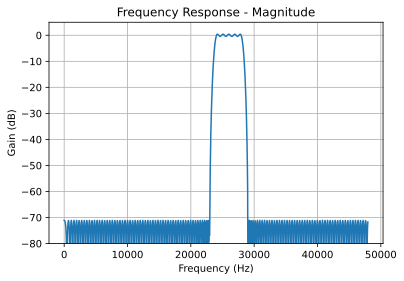

In [29]:
b_rec_bpf1 = fir_d.fir_remez_bpf(23000,24000,28000,29000,0.5,70,96000,8)
fir_d.freqz_resp_list([b_rec_bpf1],[1],mode='dB',fs=96000)
ylim([-80, 5])
grid();

Delay grup datar (konstan) karena desain memiliki fase linear.

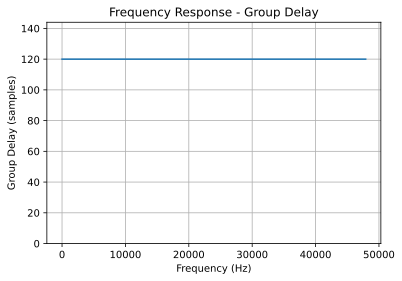

In [30]:
b_rec_bpf1 = fir_d.fir_remez_bpf(23000,24000,28000,29000,0.5,70,96000,8)
fir_d.freqz_resp_list([b_rec_bpf1],[1],mode='groupdelay_s',fs=96000)
grid();

Bandingkan desain FIR dengan desain eliptikal:

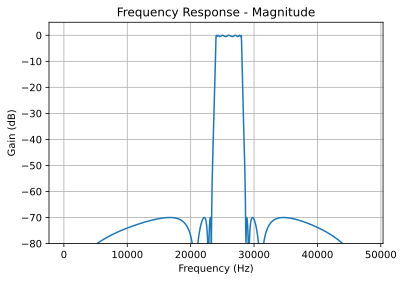

In [31]:
b_rec_bpf2,a_rec_bpf2,sos_rec_bpf2 = iir_d.IIR_bpf(23000,24000,28000,29000,
                                                   0.5,70,96000,'ellip')
with np.errstate(divide='ignore'):
    iir_d.freqz_resp_cas_list([sos_rec_bpf2],mode='dB',fs=96000)
ylim([-80, 5])
grid();


Elliptical orde tinggi ini memiliki respons amplitudo yang bagus dan rapat untuk jumlah koefisien minimal, tetapi delay grupnya buruk:

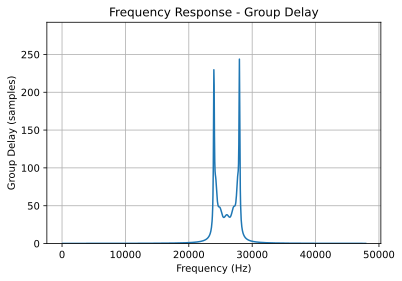

In [32]:
with np.errstate(divide='ignore', invalid='ignore'): #manage singularity warnings
    iir_d.freqz_resp_cas_list([sos_rec_bpf2],mode='groupdelay_s',fs=96000)
#ylim([-80, 5])
grid();